In [1]:
# from IPython.display import HTML

# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
from math import pi
from itertools import combinations_with_replacement
import pickle
from IPython.display import display
# pd.set_option('display.max_rows', 500)
# pd.options.display.max_colwidth=100
from natsort import natsorted
import seaborn as sns
import scipy.stats as stats 
from collections import Counter
from itertools import groupby
from operator import itemgetter
from itertools import combinations
import time
import math as math
import choix
from astropy.stats import median_absolute_deviation
import plotly.graph_objects as go

# Functions

In [3]:
def radarPlotDF(countsdf,maxpt,title,**kwargs):
    """
    makes a radar plot from a dataframe with the first two columns being
    used as 'pre' and 'post

    countssdf: a 2 column dataframe with counts
    maxpt: how to scale

    optional-
    colorcode: put color code or not? 'on' if yes.
    """
    colorcode=kwargs.get('colorcode',None)
    #set up colors
    hues=np.linspace(0,1,16,endpoint=False)
    hues=['%1.2f' % i for i in hues]
    hues=[float(i) for i in hues]
    colors = plt.cm.hsv(hues)
    # Compute pie slices
    N = 16
    theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
    radii = np.repeat(1,N)
    width = np.repeat(0.25,N)

    #set up data
    counts_df1=countsdf.iloc[:,0]
    counts_df2=countsdf.iloc[:,1]
    categories1=[str(i) for i in counts_df1.index]#cars
    N = len(categories1)
    #cars
    values1=[i for i in counts_df1.values]
    values1 += values1[:1] #makes it circular
    values2=[i for i in counts_df2.values]
    values2 += values2[:1] #makes it circular
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    #this doesn't change for all. all have 16 data points
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)
    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories1, color='grey', size=8)
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([i for i in np.arange(0,maxpt)],[],color="black", size=5)
    plt.ylim(0,maxpt)
    # Plot data
    ax.plot(angles, values1, linewidth=1, linestyle='solid')
    ax.plot(angles, values2, linewidth=1, linestyle='solid')
    # Fill area
    ax.fill(angles, values1, 'b', alpha=0.1)
    ax.fill(angles, values2, 'r', alpha=0.1)
    if colorcode=='on':
      bars = ax.bar(theta, radii, width=width, bottom=15, color=colors)
    ax.legend(['Pre','Post'])
    plt.title(title)
    
def interactiveRadar(countsDF,subname,category):
    counts_df1=countsDF.iloc[:,0]#pre
    counts_df2=countsDF.iloc[:,1]#post
    counts_df3=countsDF.iloc[:,2]#pre
    categories1=[str(i)[0:7] for i in counts_df1.index]#shirts
    N = len(categories1)

    values1=[i for i in counts_df1.values]
    values1 += values1[:1] #makes it circular
    values2=[i for i in counts_df2.values]
    values2 += values2[:1] #makes it circular
    values3=[i for i in counts_df3.values]
    values3 += values3[:1] #makes it circular


    fig = go.Figure()
    
    #plot pre
    fig.add_trace(go.Scatterpolar(
        opacity=0.75,
          r=values1,
          theta=categories1,
          fill='toself',
          name='Pre'
    ))
    #plot post
    fig.add_trace(go.Scatterpolar(
        opacity=0.75,
          r=values2,
          theta=categories1,
          fill='toself',
          name='Post '
    ))
    #plot follow-up
    fig.add_trace(go.Scatterpolar(
        opacity=0.75,
        r=values3,
        theta=categories1,
        fill='toself',
        name='3 Day '
    ))

    fig.update_layout(
    title=subname+' '+ category,
      polar=dict(
        radialaxis=dict(
          visible=True,
            showline=False,
              range=[0, 16]
        )),
      showlegend=True
    )

    fig.show()


def getPercentile(data):
    p=[]
    for q in [np.concatenate((np.arange(1,6,1),np.arange(95,100,1)))]:
        p.append(np.percentile(data,q))
        # print ("{}%% percentile: {}".format (q, np.percentile(randSim.aveAllMag, q)))
    percentiles=pd.DataFrame(p,columns=q)
    return(percentiles)
def cdfTable(data,binz,spacing):
    cdf=plt.hist(data,bins=np.arange(1,binz,spacing),density=True,cumulative=True)[0]
    plt.close()
    cdftable=pd.DataFrame(cdf,index=np.arange(1,binz-spacing,spacing))
    return(cdftable.T)
def mycdf(data):
    data_size=len(data)
    # Set bins edges
    data_set=sorted(set(data))
    bins=np.append(data_set, data_set[-1]+1)
    # Use the histogram function to bin the data
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    counts=counts.astype(float)/data_size
    # Find the cdf
    cdf = np.cumsum(counts)
    # Plot the cdf
    plt.plot(bin_edges[0:-1], cdf,linestyle='--', marker="o", color='b')
    plt.ylim((0,1))
    plt.ylabel("CDF")
    plt.grid(True)
  # plt.show()
def colorcode(value):
    """
    Colors elements in a dateframe
    green if over 0.95
    """
    ncomp=3
    if value >= 1-(0.01/ncomp) or value <= (0.01/ncomp):
        color = 'green'
    else:
        color = 'black'
    return 'color: %s' % color
def getPscore(data,score):
    pscore=stats.percentileofscore(data,score,kind='mean')
    return(pscore/100)


In [4]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]
def score(df,stim,winner):
    if winner==stim[0]: #if first of pair is winner
        if np.isnan(df[stim[0]][stim[1]]):#if is nan
            df[stim[0]][stim[1]]=1 #go to that coordinate and put 1 
        else:
            df[stim[0]][stim[1]]+=1#if not nan, then can add to it

        if np.isnan(df[stim[1]][stim[0]]): #if symmetric pair is nan
            df[stim[1]][stim[0]]=0 #go to symmetric coordinate and set to 0
        else:
            None
            #keep it to where it is
    if winner==stim[1]: #if first of pair is winner
        if np.isnan(df[stim[1]][stim[0]]):#if is nan
            df[stim[1]][stim[0]]=1 #go to that coordinate and put 1 
        else:
            df[stim[1]][stim[0]]+=1#if not nan, then can add to it

        if np.isnan(df[stim[0]][stim[1]]): #if symmetric pair is nan
            df[stim[0]][stim[1]]=0 #go to symmetric coordinate and set to 0
        else:
            None
def MaxLikBT(M,n,npar):
    Wi=np.sum(M).values#sum columns
    par=np.ones([1,npar])/npar
#     import pdb; pdb.set_trace()
    for i in range(1000):
        pi = np.ones([npar,1])*par;
        pj = pi.T
        par = Wi/np.sum(n/(pi+pj),axis=1)#sum columns, divide actual counts by it
#         par=(par-np.min(par))/(np.max(par)-np.min(par))#minmax normalization    
        par = par/np.sum(par)#normalize
    return(par)
def BTTest(par,npar):
    """
    returnint transposed so p= pwin(col) over row
    """
    M1=np.ones([npar,1])*par;#creates a 12x12 matrix from par, so now 12 rows of par which was 1x12
    M2=M1.T
    pij = M2/(M1+M2)
    np.fill_diagonal(pij,0)
    return(pij.T)
def getPij(compMat,n,npar):
    """compMat is the matrix of competitions (1/0 for win or loss)
    -n is number of comparisons
    -npar is the number of parameters (shape of compMat)
    """
    par=MaxLikBT(compMat,n,npar)
    #par gives back
    pij=BTTest(par,npar)
    return(pij)
"""
------------------------------------------------------------------------------------------------------------------------
plotting
------------------------------------------------------------------------------------------------------------------------
"""

def radarPlotDF(countsdf,maxpt,title,**kwargs):
    """
    makes a radar plot from a dataframe with the first two columns being
    used as 'pre' and 'post

    countssdf: a 2 column dataframe with counts
    maxpt: how to scale

    optional-
    colorcode: put color code or not? 'on' if yes.
    """
    colorcode=kwargs.get('colorcode',None)
    #set up colors
#     hues=np.linspace(0,1,20,endpoint=False)
#     hues=['%1.2f' % i for i in hues]
#     hues=[float(i) for i in hues]
#     colors = plt.cm.hsv(hues)
#     colors=[[0.7137254901960784, 0.0, 0.0],
#  [0.9254901960784314, 0.615686274509804, 0.0],
#  [0.5411764705882353, 0.40784313725490196, 0.0],
#  [1.0, 0.9607843137254902, 0.5215686274509804],
#  [0.5725490196078431, 0.7215686274509804, 0.3254901960784314],
#  [0.4627450980392157, 1.0, 0.0],
#  [0.0, 0.5490196078431373, 0.0],
#  [0.0, 0.2627450980392157, 0.00392156862745098],
#  [0.0, 0.9529411764705882, 0.8],
#  [0.0, 0.4823529411764706, 0.4117647058823529],
#  [0.00392156862745098, 0.6470588235294118, 0.792156862745098],
#  [0.6705882352941176, 0.8313725490196079, 1.0],
#  [0.0, 0.0, 0.5607843137254902],
#  [0.3803921568627451, 0.0, 0.6392156862745098],
#  [0.7647058823529411, 0.30980392156862746, 1.0],
#  [0.9294117647058824, 0.7176470588235294, 1.0],
#  [0.5803921568627451, 0.0, 0.45098039215686275],
#  [0.3607843137254902, 0.0, 0.06666666666666667],
#  [0, 0, 0],
#  [1, 1, 1]]

    colors=[[0.7137254901960784, 0.0, 0.0],
 [0.9254901960784314, 0.615686274509804, 0.0],
 [0.5411764705882353, 0.40784313725490196, 0.0],
 [1.0, 0.9607843137254902, 0.5215686274509804],
 [0.5725490196078431, 0.7215686274509804, 0.3254901960784314],
 [0.4627450980392157, 1.0, 0.0],
 [0.0, 0.5490196078431373, 0.0],
 [0.0, 0.2627450980392157, 0.00392156862745098],
 [0.0, 0.9529411764705882, 0.8],
 [0.0, 0.4823529411764706, 0.4117647058823529],
 [0.00392156862745098, 0.6470588235294118, 0.792156862745098],
 [0.6705882352941176, 0.8313725490196079, 1.0],
 [0.0, 0.0, 0.5607843137254902],
 [0.3803921568627451, 0.0, 0.6392156862745098],
 [0.7647058823529411, 0.30980392156862746, 1.0],
 [0.9294117647058824, 0.7176470588235294, 1.0],
 [0.5803921568627451, 0.0, 0.45098039215686275],
 [0.3607843137254902, 0.0, 0.06666666666666667]]
    
    # Compute pie slices
    N = 18
    theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
    radii = np.repeat(1,N)
    width = np.repeat(0.25,N)

    #set up data
    counts_df1=countsdf.iloc[:,0]
    counts_df2=countsdf.iloc[:,1]
    categories1=[str(i) for i in counts_df1.index]#cars
    N = len(categories1)
    #cars
    values1=[i for i in counts_df1.values]
    values1 += values1[:1] #makes it circular
    values2=[i for i in counts_df2.values]
    values2 += values2[:1] #makes it circular
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    #this doesn't change for all. all have 16 data points
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)
    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories1, color='grey', size=8)
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([i for i in np.arange(0,maxpt)],[],color="black", size=5)
    plt.ylim(0,maxpt)
    # Plot data
    ax.plot(angles, values1, linewidth=1, linestyle='solid')
    ax.plot(angles, values2, linewidth=1, linestyle='solid')
    # Fill area
    ax.fill(angles, values1, 'b', alpha=0.1)
    ax.fill(angles, values2, 'r', alpha=0.1)
    if colorcode=='on':
      bars = ax.bar(theta, radii, width=width, bottom=19, color=colors)
    ax.legend(['Pre','Post'])
    plt.title(title)
    
def interactiveRadar(countsDF,subname,category):
    counts_df1=countsDF.iloc[:,0]#pre
    counts_df2=countsDF.iloc[:,1]#post
    counts_df3=countsDF.iloc[:,2]#fup
    
    categories1=[str(i)[0:7] for i in counts_df1.index]#shirts
    N = len(categories1)

    values1=[i for i in counts_df1.values]
    values1 += values1[:1] #makes it circular
    values2=[i for i in counts_df2.values]
    values2 += values2[:1] #makes it circular
    values3=[i for i in counts_df3.values]
    values3 += values3[:1] #makes it circular


    fig = go.Figure()
    
    #plot pre
    fig.add_trace(go.Scatterpolar(
        opacity=0.75,
          r=values1,
          theta=categories1,
          fill='toself',
          name='Pre'
    ))
    #plot post
    fig.add_trace(go.Scatterpolar(
        opacity=0.75,
          r=values2,
          theta=categories1,
          fill='toself',
          name='Post '
    ))
    #plot follow-up
    fig.add_trace(go.Scatterpolar(
        opacity=0.75,
        r=values3,
        theta=categories1,
        fill='toself',
        name='3 Day '
    ))

    fig.update_layout(
    title=subname+' '+ category,
      polar=dict(
        radialaxis=dict(
          visible=True,
            showline=False,
              range=[0, len(countsDF)]
        )),
      showlegend=True
    )

    fig.show()

"""
------------------------------------------------------------------------------------------------------------------------
data tables
------------------------------------------------------------------------------------------------------------------------
"""
def getPercentile(data):
    p=[]
    for q in [np.concatenate((np.arange(1,6,1),np.arange(95,100,1)))]:
        p.append(np.percentile(data,q))
        # print ("{}%% percentile: {}".format (q, np.percentile(randSim.aveAllMag, q)))
    percentiles=pd.DataFrame(p,columns=q)
    return(percentiles)
def cdfTable(data,binz,spacing):
    cdf=plt.hist(data,bins=np.arange(1,binz,spacing),density=True,cumulative=True)[0]
    plt.close()
    cdftable=pd.DataFrame(cdf,index=np.arange(1,binz-spacing,spacing))
    return(cdftable.T)
def mycdf(data):
    data_size=len(data)
    # Set bins edges
    data_set=sorted(set(data))
    bins=np.append(data_set, data_set[-1]+1)
    # Use the histogram function to bin the data
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    counts=counts.astype(float)/data_size
    # Find the cdf
    cdf = np.cumsum(counts)
    # Plot the cdf
    plt.plot(bin_edges[0:-1], cdf,linestyle='--', marker="o", color='b')
    plt.ylim((0,1))
    plt.ylabel("CDF")
    plt.grid(True)
  # plt.show()
def colorcode(value):
    """
    Colors elements in a dateframe
    green if over 0.95
    """
    if value >= 0.9975 or value <= 0.0025:
        color = 'green'
    else:
        color = 'black'
    return 'color: %s' % color
def getPscore(data,score):
    pscore=stats.percentileofscore(data,score,kind='mean')
    return(pscore/100)

"""
------------------------------------------------------------------------------------------------------------------------
esd
------------------------------------------------------------------------------------------------------------------------
"""

  #ESD
def grubbs_stat(y):
    """
    -max deviation is 2 sided!
    -if multiple, picks the first one in the array
    """
    std_dev = np.std(y)
    avg_y = np.mean(y)
    abs_val_minus_avg = abs(y - avg_y)
    max_of_deviations = max(abs_val_minus_avg)
    max_ind = np.argmax(abs_val_minus_avg)
    Gcal = max_of_deviations/ std_dev
#     print("Grubbs Statistics Value : {}".format(Gcal))
    return Gcal, max_ind
def calculate_critical_value(size, alpha):
    """Calculate the critical value with the formula given for example in
    https://en.wikipedia.org/wiki/Grubbs%27_test_for_outliers#Definition
    Args:
        ts (list or np.array): The timeseries to compute the critical value.
        alpha (float): The significance level.
    Returns:
        float: The critical value for this test.
    """
    t_dist = stats.t.ppf(1 - alpha / (2 * size), size - 2)
    numerator = (size - 1) * np.sqrt(np.square(t_dist))
    denominator = np.sqrt(size) * np.sqrt(size - 2 + np.square(t_dist))
    critical_value = numerator / denominator
#     print("Grubbs Critical Value: {}".format(critical_value))
    return critical_value
def check_G_values(Gs, Gc, inp, max_index):
    if Gs > Gc:
        print('{} is an outlier. G > G-critical: {:.4f} > {:.4f} \n'.format(inp[max_index], Gs, Gc))
    else:
        print('{} is not an outlier. G > G-critical: {:.4f} > {:.4f} \n'.format(inp[max_index], Gs, Gc))
def ESD_Test(input_series, alpha, max_outliers):
    Gcritical_List=[]
    max_index_List=[]
    Gstat_List=[]
    inputOrig=input_series.copy()
    for iterations in range(max_outliers):
        Gcritical = calculate_critical_value(len(input_series), alpha)
        Gstat, max_index = grubbs_stat(input_series)
#         check_G_values(Gstat, Gcritical, input_series, max_index)
        input_series = np.delete(input_series, max_index)
        
        Gcritical_List.append(Gcritical)
        max_index_List.append(max_index)
        Gstat_List.append(Gstat)
        
    GDf=pd.DataFrame({'Gcritical':Gcritical_List,'max_val':[inputOrig[i] for i in max_index_List],'Gstat':Gstat_List})
    GDf['outlier']=np.where(GDf.Gstat>GDf.Gcritical,1,0)
    
    outlsNZ=np.nonzero(GDf.outlier.values)[0]
    t=[outlsNZ[i]==i for i in np.arange(len(outlsNZ))]
    t2=[i for i, x in enumerate(t) if x]
    tot=np.sum(list(GDf.outlier.values[t2]))
    return(GDf,tot)

"""
------------------------------------------------------------------------------------------------------------------------
counts
------------------------------------------------------------------------------------------------------------------------
"""
def getPreLengths(countsdf):
    '''
    gets the indices where 'pre' is greater than 'post',npar is the number of items,competition df is a df of counts
    pre and post
    '''
    npar=len(countsdf)
    #IF >= MEANS COUNTS TIES (0) FOR BOTH STRINGS!
    pre=np.where(countsdf.iloc[:,0]>=countsdf.iloc[:,1])[0]#indices where pre>post
    addCircle=all(x in pre for x in [npar-1,0])#if any of the strings are at edges then have to make circular
    prelist=[]
    for k,g in groupby(enumerate(pre),lambda ix:ix[0]-ix[1]):
        #this returns consecutive numbers. ex. if strings are [2,3,4,6,7,8,11,12]
        #will return [[2,3,4],[6,7,8],[11,12]]
        prelist.append(list(map(itemgetter(1),g)))
    prelens=[len(i) for i in prelist]
    if addCircle:#if strings at edges
        #fix lengths
        prelens[-1]=prelens[0]+prelens[-1]
        prelens.pop(0)
        #fix lists indices
        lnf=[[item for sublist in [prelist[-1],prelist[0]] for item in sublist]]#join the last and first items
        rest=prelist[1:-1]#get everyting except last and first
        joined=[rest,lnf]# put together
        prelist=[item for sublist in joined for item in sublist]
    zeroIDX=np.where(countsdf.iloc[:,2]==0)[0]
    for i in prelist:
      for k in zeroIDX:
        if k in i:
          i.remove(k)
    prelist=[x for x in prelist if x!=[]]
    return(prelist)
def getPostLengths(countsdf):
    npar=len(countsdf)
    #IF >= MEANS COUNTS TIES (0) FOR BOTH STRINGS!
    post=np.where(countsdf.iloc[:,1]>=countsdf.iloc[:,0])[0]
    addCircle=all(x in post for x in [npar-1,0])
    postlist=[]
    for k,g in groupby(enumerate(post),lambda ix:ix[0]-ix[1]):
        postlist.append(list(map(itemgetter(1),g)))
        #     print('string indices')
        #     print(postlist)
    postlens=[len(i) for i in postlist]
    if addCircle:
        postlens[-1]=postlens[0]+postlens[-1]
        postlens.pop(0)
        #fix lists indices
        lnf=[[item for sublist in [postlist[-1],postlist[0]] for item in sublist]]#join the last and first items
        rest=postlist[1:-1]#get everyting except last and first
        joined=[rest,lnf]# put together
        postlist=[item for sublist in joined for item in sublist]
          #     print('string lengths')
    zeroIDX=np.where(countsdf.iloc[:,2]==0)[0]
    for i in postlist:
      for k in zeroIDX:
        if k in i:
          i.remove(k)
    postlist=[x for x in postlist if x!=[]]
    return(postlist)

def getCountsInfo(countsdf):
    """
    combines count getter and does further computations on them.
    """
    pre=countsdf.iloc[:,0].values
    post=countsdf.iloc[:,1].values
    #string Idx
    preIdx=getPreLengths(countsdf)#get pre strings
    postIdx=getPostLengths(countsdf)#get post strings

    #flattened string idx
    preFlat=[item for sublist in preIdx for item in sublist]
    postFlat=[item for sublist in postIdx for item in sublist]
    allFlat=preFlat+postFlat

    #diff values
    preDiff=np.abs(countsdf.iloc[:,2].iloc[preFlat].values)
    postDiff=np.abs(countsdf.iloc[:,2].iloc[postFlat].values)
    allDiff=np.abs(countsdf.iloc[:,2].iloc[allFlat].values)#CHANGE MADE was countsdf['DIFF'].values) so was counting zeros
    allDiffz=np.abs(countsdf.iloc[:,2].values)

    #length of each string
    preLen=[len(i) for i in preIdx]
    postLen=[len(i) for i in postIdx]
    allLen=preLen+postLen

    # of total strings
    preNumStr=len(preLen)
    postNumStr=len(postLen)
    allNumStr=preNumStr+postNumStr

    #average string length
    avePreStrLen=np.sum(preLen)/preNumStr
    avePostStrLen=np.sum(postLen)/postNumStr
    aveAllStrLen=np.sum(allLen)/allNumStr

    #sum of those individual strings
    preSumStr=np.abs([np.sum(countsdf.iloc[:,2][i]) for i in preIdx])#sum of each string pre
    postSumStr=np.abs([np.sum(countsdf.iloc[:,2][i]) for i in postIdx]) #sum of each string post
    allSumStr=np.concatenate([[i for i in preSumStr],[i for i in postSumStr]])#combined sum of all strings

    #overall sum of pre and post 
    preOverallStrSum=np.sum(preSumStr)
    postOverallStrSum=np.sum(postSumStr)
    allOverallStrSum=np.sum(allSumStr)

    #average sum of a string pre/post
    avePreStrSum=preOverallStrSum/preNumStr
    avePostStrSum=postOverallStrSum/postNumStr
    aveAllStrSum=allOverallStrSum/allNumStr

    kD=choix.kendalltau_dist(pre,post)
    
    ESD=ESD_Test(allDiffz,0.05,3)[1]

    outDF=pd.DataFrame([preNumStr,postNumStr,allNumStr,
                      avePreStrLen,avePostStrLen,aveAllStrLen,
                      preOverallStrSum,postOverallStrSum,allOverallStrSum,
                      avePreStrSum,avePostStrSum,aveAllStrSum,
                      preIdx,postIdx,
                      preFlat,postFlat,allFlat,
                      preLen,postLen,allLen,
                      preDiff,postDiff,allDiff,allDiffz,
                      preSumStr,postSumStr,allSumStr,pre,post,kD,ESD]).T
    outDF.columns=(['preNumStr','postNumStr','allNumStr',
                      'avePreStrLen','avePostStrLen','aveAllStrLen',
                      'preOverallStrSum','postOverallStrSum','allOverallStrSum',
                      'avePreStrSum','avePostStrSum','aveAllStrSum',
                      'preIdx','postIdx',
                      'preFlat','postFlat','allFlat',
                      'preLen','postLen','allLen',
                      'preDiff','postDiff','allDiff','allDiffz',
                      'preSumStr','postSumStr','allSumStr','pre','post','kD','ESD'])
    return(outDF)



# About

All statistics are split into two categories, counts and ranks. The simulations were run with both ranks and counts. Counts statistics look solely at the number of wins, but do not consider the relative relationship of the counts within a list. The ranking method does. If there are ties, an average of the rank is given

The true counts of each subject do show differences in the counts and ranks statistics, (except for kD, which is based on ranks for both anyway). These differences are not major and there is a correlation, but the differences can be seen from the radar plots as well. 

There are some differences in the overall outcomes of the tests in counts vs. ranks


**aveAllStrLen**: average length of the string. calculated as the overall length of pre and post strings divided by the total # of strings

*    if no ties, total len must add to 16, so ranges from 16/2 =>8 to 16/16 =>1, anti-correlated with allNumStr. 
*     decreases with spikeyness

**ESD**: uses the grubbs test sequentially to test for up to n number of outliers. here setting n=3,sig=0.05

**kD**: distance metric derived from kendall to indicate dissimilarity or distance between two lists. proceeds by ranking and then computing number of rank order disagreements



In [5]:
def getFinal(df):
    """
    makes a final table of all statistics
    """
    checkVal=1-(0.01/3)
    subkeeper=[i for i in df.columns]
    Results=pd.DataFrame({'Range':df.loc['aveAllStrLen'].gt(checkVal).values,
                          'Outlier':df.loc['ESD'].gt(checkVal).values,
#                           'Mixed':df.loc['allOverallStrSum'].gt(checkVal).values,
                         'kD': df.loc['kD'].gt(checkVal).values},index=df.columns)
#     return(Results)
    Results['None']=[not(Results.loc[i].any()) for i in df.columns]
    NoneKeeper=Results.index[Results['None']].values
    [subkeeper.remove(i) for i in NoneKeeper]
    RangeKeeper=Results.index[Results.Range]
    [subkeeper.remove(i) for i in RangeKeeper]
    OutlierKeeper=Results.index[Results.Outlier]
    [subkeeper.remove(i) for i in OutlierKeeper]
    kDKeeper=Results.index[Results.kD]
#     [subkeeper.remove(i) for i in kDKeeper]
    return(pd.DataFrame({'Range':[[int(re.findall(r'\d+',i)[0]) for i in RangeKeeper]],
                         'Outlier':[[int(re.findall(r'\d+',i)[0]) for i in OutlierKeeper]],
#                          'Mixed':[[int(re.findall(r'\d+',i)[0]) for i in subkeeper]],
                         'kD':[[int(re.findall(r'\d+',i)[0]) for i in kDKeeper]],
                         'None':[[int(re.findall(r'\d+',i)[0]) for i in NoneKeeper]]}))

# load first visit

In [6]:
finalMatchSubs=['sub3','sub7','sub8','sub9','sub10','sub11','sub12','sub13','sub15','sub16','sub18','sub20',
 'sub23','sub24','sub25','sub26','sub28','sub30','sub31','sub33','sub35','sub36','sub37','sub38',
 'sub40','sub41','sub44','sub45','sub46','sub47','sub48','sub49','sub50','sub51','sub1','sub2','sub5','sub6','sub14','sub19','sub22','sub29','sub32','sub39','sub42']
finalMatchSubs=natsorted(finalMatchSubs)

# Shirts

In [7]:
checkList=['aveAllStrLen','ESD','kD']

## True Counts - (Pre-Post) AB

### counts based

In [8]:
#subject clas for loading
class Subject():
    def __init__(self,subname):
        self.subname=subname
#load
os.chdir(r"C:\Users\al33m\Box Sync\Grzywacz Lab\Experiment\Data_Files\scp\Visit2\pickleABC\together")
subs={}
for i in finalMatchSubs:
    print(i)
    with open(i+'.pkl', 'rb') as input:
        subs[i] = pickle.load(input)


sub1
sub2
sub3
sub5
sub6
sub7
sub8
sub9
sub10
sub11
sub12
sub13
sub14
sub15
sub16
sub18
sub19
sub20
sub22
sub23
sub24
sub25
sub26
sub28
sub29
sub30
sub31
sub32
sub33
sub35
sub36
sub37
sub38
sub39
sub40
sub41
sub42
sub44
sub45
sub46
sub47
sub48
sub49
sub50
sub51


In [11]:
Cars_AB_trueCounts=[]
Cars_AC_trueCounts=[]


for i in subs.keys():
    Cars_AB_trueCounts.append(pd.DataFrame(getCountsInfo(subs[i].ABC_CarsCounts)))#takes 0 and 1 2
    Cars_AC_trueCounts.append(pd.DataFrame(getCountsInfo(subs[i].ABC_CarsCounts.iloc[:,np.r_[0,2,3]])))



now load with sim

In [12]:
#subject clas for loading
class Subject():
    def __init__(self,subname):
        self.subname=subname
#load
os.chdir(r"C:\Users\al33m\Box Sync\Grzywacz Lab\Experiment\Data_Files\scp\Sim\AC\Cars")
subs={}
for i in finalMatchSubs:
    print(i)
    with open(i+'.pkl', 'rb') as input:
        subs[i] = pickle.load(input)

sub1
sub2
sub3
sub5
sub6
sub7
sub8
sub9
sub10
sub11
sub12
sub13
sub14
sub15
sub16
sub18
sub19
sub20
sub22
sub23
sub24
sub25
sub26
sub28
sub29
sub30
sub31
sub32
sub33
sub35
sub36
sub37
sub38
sub39
sub40
sub41
sub42
sub44
sub45
sub46
sub47
sub48
sub49
sub50
sub51


add attributes manually

In [13]:
k=0
for i in finalMatchSubs:
    subs[i].AB_CarsTrueCounts=Cars_AB_trueCounts[k]
    subs[i].AC_CarsTrueCounts=Cars_AC_trueCounts[k]
    k=k+1

## True Counts - (Pre-FollowUp) AC

### from counts

In [14]:
#make FUPsubs true counts
AC_CarsTrueCounts=pd.DataFrame()
for i in finalMatchSubs:
    AC_CarsTrueCounts=AC_CarsTrueCounts.append(subs[i].AC_CarsTrueCounts)
AC_CarsTrueCounts.index=finalMatchSubs
AC_CarsTrueCounts[checkList]

,aveAllStrLen,ESD,kD
sub1,1.125,0,7
sub2,2,0,7
sub3,1.75,0,23
sub5,6,1,22
sub6,2.75,0,17
sub7,2.5,0,16
sub8,2.16667,0,12
sub9,2,0,15
sub10,2,0,9
sub11,3,0,8


## Simulation - (Pre-FollowUp) AC

### from counts

In [15]:
AC_CarsCountTestDF=pd.DataFrame()
for i in finalMatchSubs:
  Pscore=[]
  # print(i)
  for measure in checkList:
    # print(measure)
    Pscore.append(getPscore(getattr(subs[i],'AC_CarsCountsInfoSim')[measure],subs[i].AC_CarsTrueCounts[measure][0]))
  AC_CarsCountTestDF=AC_CarsCountTestDF.append(pd.DataFrame(Pscore).T)
AC_CarsCountTestDF.columns=checkList
AC_CarsCountTestDF.index=[i for i in subs.keys()]
AC_CarsCountTestDF=AC_CarsCountTestDF.T
AC_CarsCountTestDF.style.applymap(colorcode)

,sub1,sub2,sub3,sub5,sub6,sub7,sub8,sub9,sub10,sub11,sub12,sub13,sub14,sub15,sub16,sub18,sub19,sub20,sub22,sub23,sub24,sub25,sub26,sub28,sub29,sub30,sub31,sub32,sub33,sub35,sub36,sub37,sub38,sub39,sub40,sub41,sub42,sub44,sub45,sub46,sub47,sub48,sub49,sub50,sub51
aveAllStrLen,0.061,0.762,0.463,0.999,0.9175,0.8985,0.849,0.6875,0.7945,0.9675,0.9275,0.5375,0.936,0.6225,0.6315,0.9505,0.83,0.7695,0.822,0.2955,0.675,0.722,0.8675,0.7915,0.776,0.946,0.0825,0.3915,0.9005,0.331,0.401,0.409,0.369,0.364,0.9715,0.9305,0.32,0.971,0.9305,0.325,0.999,0.9985,0.6365,0.9955,0.9775
ESD,0.373,0.404,0.41,0.893,0.414,0.413,0.4065,0.397,0.3985,0.2275,0.8985,0.3995,0.438,0.413,0.9895,0.418,0.423,0.8945,0.384,0.421,0.422,0.3935,0.415,0.412,0.407,0.4095,0.4295,0.4005,0.426,0.3895,0.881,0.438,0.4165,0.412,0.411,0.4075,0.4215,0.3655,0.4245,0.4375,0.403,0.4225,0.423,0.4135,0.4225
kD,0.7,0.9765,0.998,0.989,0.987,0.9995,0.957,0.7945,0.9675,0.9975,1,0.981,0.992,0.9845,1,0.9385,0.991,0.955,0.95,0.88,0.9915,1,0.7155,1,0.9855,0.9905,0.8645,1,1,0.999,0.989,0.374,0.9955,0.801,0.9925,0.77,0.8995,0.9975,0.602,0.9385,1,0.8235,0.986,0.999,0.8995


In [18]:
AC_Cars_Final=getFinal(AC_CarsCountTestDF)
AC_Cars_Final

,Range,Outlier,kD,None
0,"[5, 47, 48]",[],"[3, 7, 11, 12, 16, 25, 28, 32, 33, 35, 44, 47,...","[1, 2, 6, 8, 9, 10, 13, 14, 15, 18, 19, 20, 22..."


In [20]:
print('there are ' +str(len(AC_Cars_Final.Range[0]))+ ' range out of 45')
print('there are ' +str(len(AC_Cars_Final.Outlier[0]))+ ' outlier out of 45')
print('there are ' +str(len(AC_Cars_Final.kD[0]))+ ' kD out of 45')
print('there are ' +str(len(AC_Cars_Final['None'][0]))+ ' None out of 45')

there are 3 range out of 45
there are 0 outlier out of 45
there are 13 kD out of 45
there are 30 None out of 45


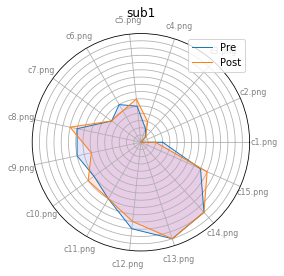

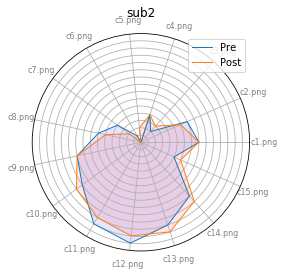

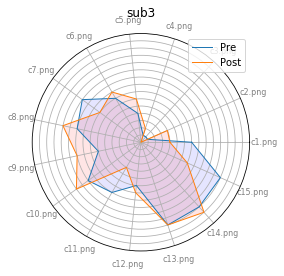

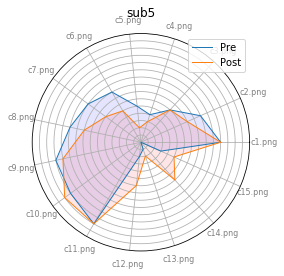

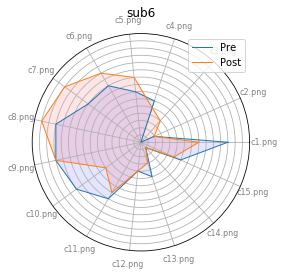

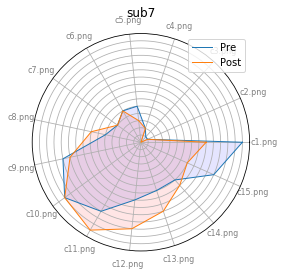

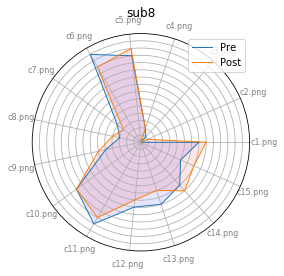

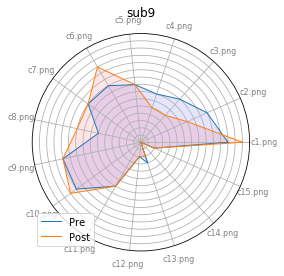

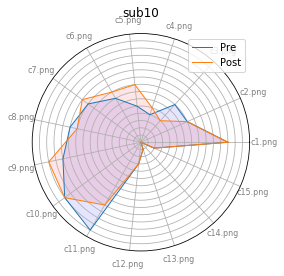

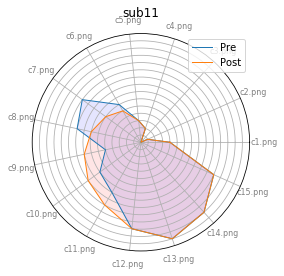

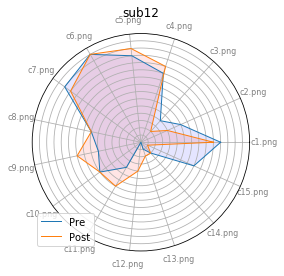

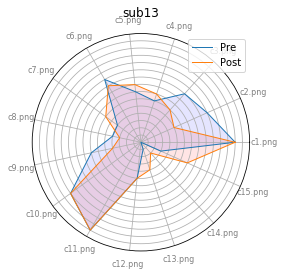

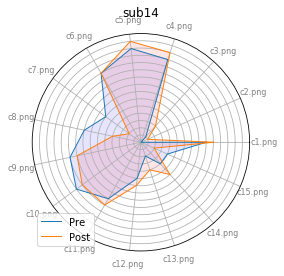

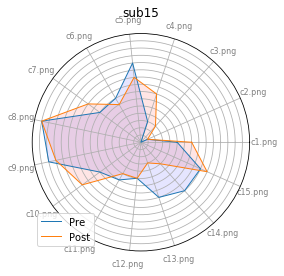

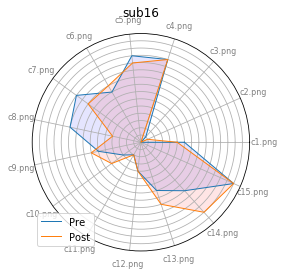

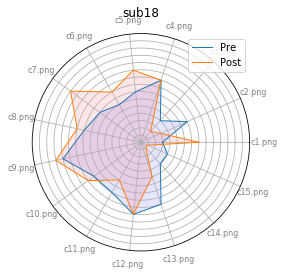

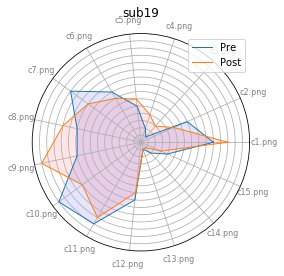

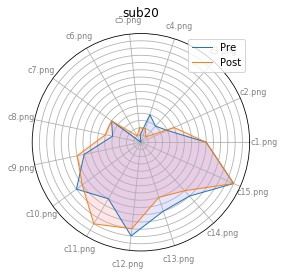

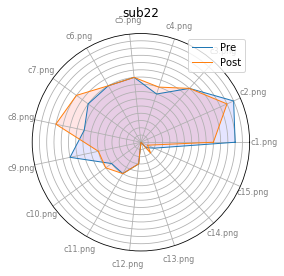

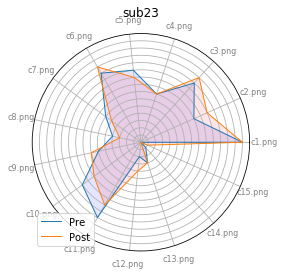

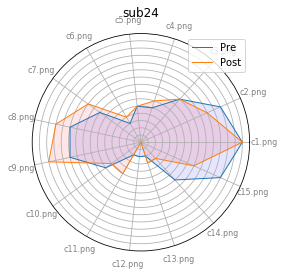

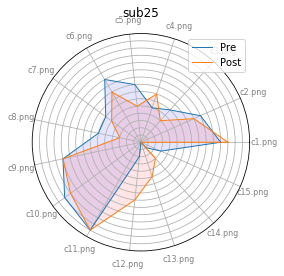

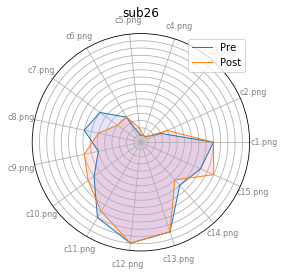

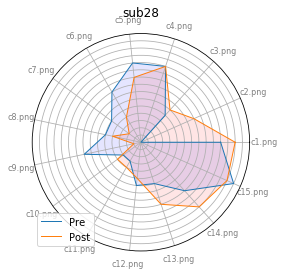

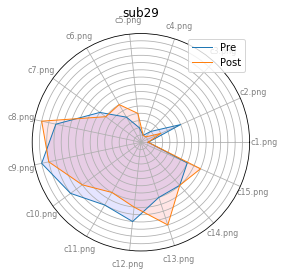

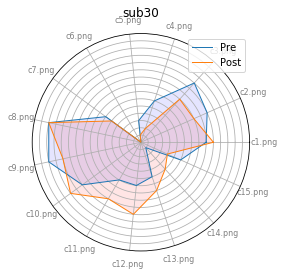

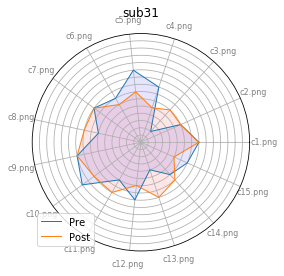

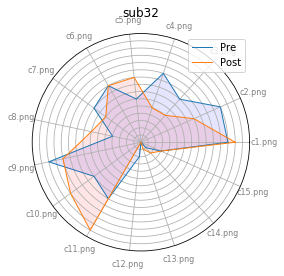

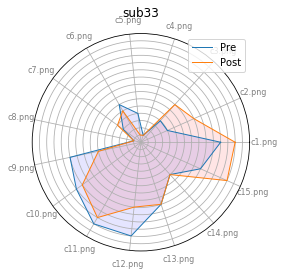

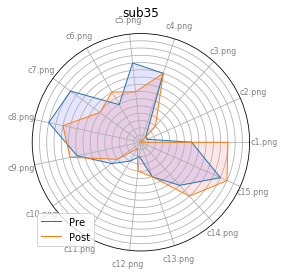

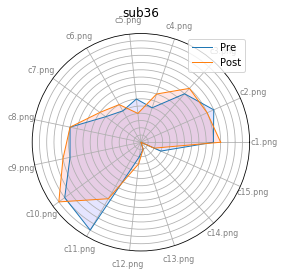

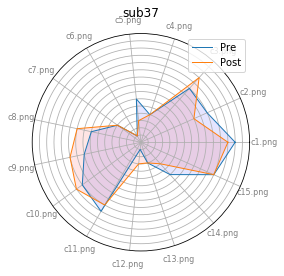

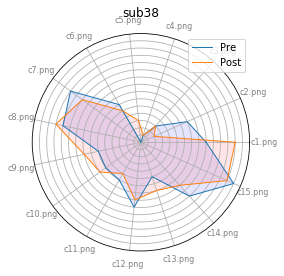

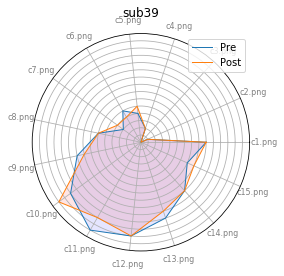

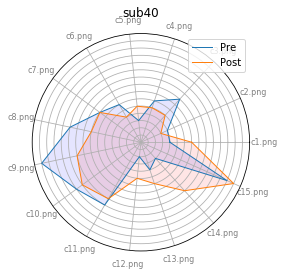

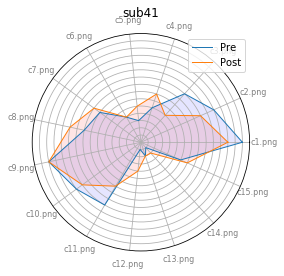

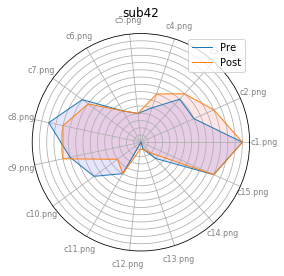

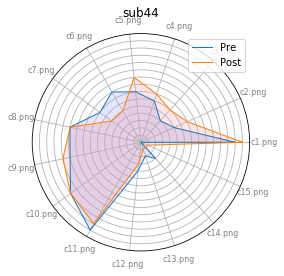

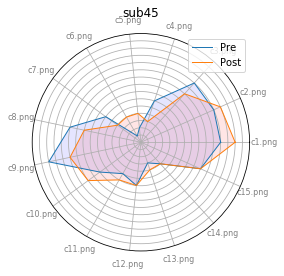

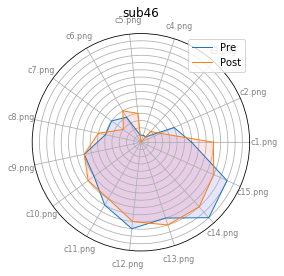

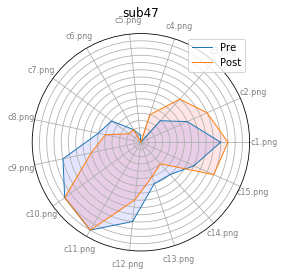

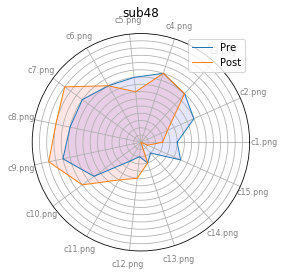

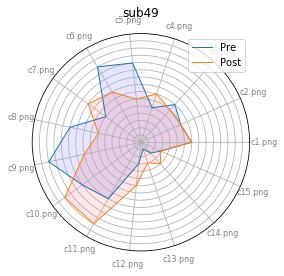

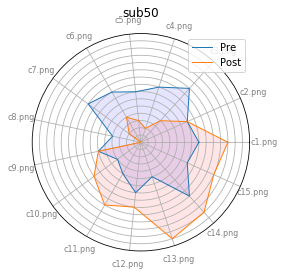

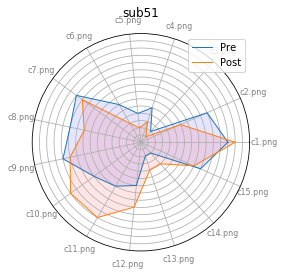

In [9]:
for i in finalMatchSubs:
    radarPlotDF(subs[i].ABC_CarsCounts.iloc[:,np.r_[0,2]],15,i)
    plt.show()